In [17]:
import os
import pathlib
import time
import zipfile
import tarfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [18]:
# !unzip -o data/imgs-20240502T035937Z-001.zip >/dev/null 2>&1;


In [19]:
# !unzip -o data/imgs-20240502T035937Z-002.zip >/dev/null 2>&1;


In [20]:
working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)


In [21]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Available GPUs: 
[]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18810 entries, 0 to 18809
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         18810 non-null  int64  
 1   gbifID             18810 non-null  int64  
 2   references         18810 non-null  object 
 3   basisOfRecord      18810 non-null  object 
 4   catalogNumber      18810 non-null  object 
 5   sex                3428 non-null   object 
 6   lifeStage          3216 non-null   object 
 7   behavior           18691 non-null  object 
 8   eventTime          17266 non-null  object 
 9   month              18768 non-null  float64
 10  continent          18810 non-null  object 
 11  countryCode        18810 non-null  object 
 12  verbatimElevation  18810 non-null  object 
 13  decimalLatitude    18741 non-null  float64
 14  decimalLongitude   18741 non-null  float64
 15  mediaType          18810 non-null  object 
 16  genus              188

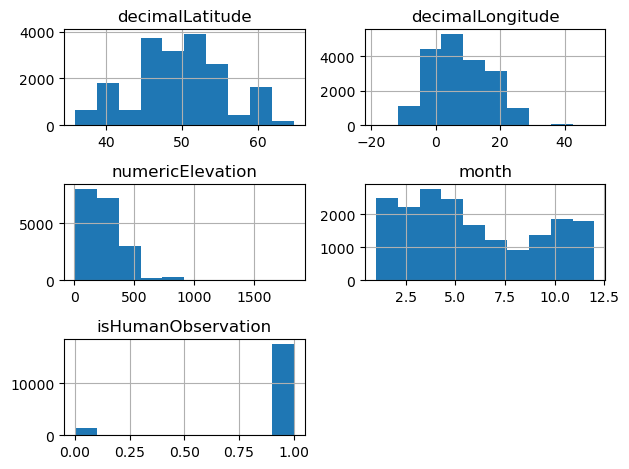

In [34]:
df = pd.read_csv('data/undersampled_top_10.csv')
print(df.info())
import re
def get_elevation(elev):
  if (elev is None):
    return None
    #special case, error in data
  if (elev == 'XC576615 m'):
    return None
  result = re.search(r'\d+', elev)
  if result is None:
    return result
  else:
    return int(result.group())

df['numericElevation'] = df['verbatimElevation'].replace(np.nan, None).apply(get_elevation)
df['isHumanObservation'] = df['basisOfRecord'].apply(lambda x : int(x == "HUMAN_OBSERVATION")) 
means_country = df[['countryCode', 'decimalLatitude', 'decimalLongitude','numericElevation']].groupby('countryCode').mean()
def impute(colName):
  def f(row):
    return means_country.loc[row["countryCode"]][colName]
  return f
      
df['decimalLatitude'] = df.apply(impute("decimalLatitude"), axis=1)
df['decimalLongitude'] = df.apply(impute('decimalLongitude'), axis=1)
df['numericElevation'] = df.apply(impute('numericElevation'), axis=1)
df[['decimalLatitude', 'decimalLongitude', 'numericElevation','month','isHumanObservation']].hist()
plt.tight_layout()
X = []
y = []
df_efficient = df.set_index('catalogNumber')



We can see that we need to encode and impute some features. For basisOfRecord, we encode it as a binary variable. For verbatim elevation, we convert it to a numerical value using regular expressions. To impute latitude, longitude, and elevation, we replace missing values with the mean of the country the recording was made. To impute the month, we just replace it with 0, since months range from 1-12. The resulting distributions of the numeric variables are shown. 

In [7]:
#Construct arrays
X = []
X_features = []
y = []
if (not (os.path.exists('data/specs_additional.npy') and os.path.exists('data/labels_additional.npy') and os.path.exists('data/features_additional.npy'))):
    for index, fname in enumerate(os.listdir('imgs/')):
        try:
            if index % 5000 == 0:
                print(f'{index} done')
            file = os.path.join('imgs', fname)
            X.append(np.array(Image.open(file)))
            basename = os.path.basename(file)
            category = basename.split("_")[0]
            row = df_efficient[df_efficient.index == category]
            species = row['species'].values
            features = row[['decimalLatitude', 'decimalLongitude', 'month', 'numericElevation', 'isHumanObservation']].to_numpy()[0]
            assert(len(species) == 1)
            y.append(species[0])
            X_features.append(features)
        except Exception as e:
            print(str(e))
            print(fname)
    images = np.array(X)
    string_labels = np.array(y)
    features = np.array(X_features)
    np.save('data/specs_additional.npy', images)
    np.save('data/labels_additional.npy', string_labels)
    np.save('data/features_additional.npy', features)
else: 
    images = np.load('data/specs_additional.npy')
    string_labels = np.load('data/labels_additional.npy')
    features = np.load('data/features_additional.npy', allow_pickle=True).astype(float)

In [8]:
import sklearn
print(features)
lookup = tf.keras.layers.StringLookup()
print(len(images))

# Fit the lookup layer to your labels
lookup.adapt(string_labels)

# Convert the string labels to integer indices
integer_encoded_labels = lookup(string_labels).numpy() - 1
print(np.bincount(integer_encoded_labels))


labels = to_categorical(integer_encoded_labels, num_classes = len(np.unique(string_labels)))
features = sklearn.preprocessing.StandardScaler().fit_transform(features)
X_train, X_test, features_train, features_test, y_train, y_test = train_test_split(images, features, labels, test_size = 0.2, stratify = labels, random_state=42)
X_train, X_val, features_train, features_val, y_train, y_val = train_test_split(X_train, features_train, y_train, test_size = 0.2, stratify = y_train, random_state=42)

print(lookup.get_vocabulary())

test_dataset = tf.data.Dataset.from_tensor_slices(({'image_input': X_test, 'feature_input': features_test}, y_test))
train_dataset = tf.data.Dataset.from_tensor_slices(({'image_input': X_train, 'feature_input': features_train}, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices(({'image_input': X_val, 'feature_input': features_val}, y_val))


[[ 46.58452502   1.99881173   3.         328.93952      1.        ]
 [ 53.68302638  -1.24501282   6.          84.75086372   1.        ]
 [ 49.43176529  10.2016655    5.         357.89140811   1.        ]
 ...
 [ 37.93650272 -10.096132     1.         132.75641026   1.        ]
 [ 53.68302638  -1.24501282   7.          84.75086372   1.        ]
 [ 50.85456964   4.35885823   5.          64.9859353    1.        ]]
115127
[20067 18368 14446 11307 11241 10477  8436  8413  8034  4338]
['[UNK]', 'Turdus merula', 'Turdus philomelos', 'Sylvia atricapilla', 'Erithacus rubecula', 'Fringilla coelebs', 'Strix aluco', 'Parus major', 'Troglodytes troglodytes', 'Phylloscopus collybita', 'Loxia curvirostra']


We convert the string labels into one hot encoded variables and standardize all the features.

In [9]:
mapping = {val: idx for idx, val in enumerate(lookup.get_vocabulary(include_special_tokens=False))}
import pickle 

with open('tf_data_additional/species_encoding.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [10]:
train_dataset.save('tf_data_additional/train_data')
test_dataset.save('tf_data_additional/test_data')
val_dataset.save('tf_data_additional/validation_data')